In [1]:
import pandas as pd
import numpy as np
import os
from os.path import exists
import opendatasets as od
import shutil
import wbgapi as wb

import requests
from io import BytesIO

In [2]:
import pycountry

def get_country_code(country_name):
    # First, try to find the country in the current countries list
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_2
    except LookupError:
        # If not found, try to find it in the historic countries list
        try:
            historic_country = pycountry.historic_countries.lookup(country_name)
            return historic_country.alpha_2
        except LookupError:
            return "Error"

In [3]:
from sklearn.linear_model import LinearRegression

def fill_future_values_last_five_years(group, value ='YR'):
    # Sort by time to ensure correct order
    group = group.sort_index(level=1)
    
    # Identify the last time period with a non-NaN value
    last_valid_index = group[value].last_valid_index()
    
    if last_valid_index:
        last_valid_time = last_valid_index[1]
        
        # Consider the last ten years of available non-NaN data for model fitting
        valid_data = group.loc[group.index.get_level_values(1) <= last_valid_time].dropna(subset=[value])
        
        # Filter to keep only the last ten years
        last_ten_years = valid_data.tail(5)
        
        if len(last_ten_years) >= 2:  # At least two data points are needed to fit a linear model
            X = last_ten_years.index.get_level_values(1).values.reshape(-1, 1)  # Time period
            y = last_ten_years[value].values  # Observed values
            model = LinearRegression().fit(X, y)
            
            # Identify future periods to predict (after the last valid time)
            future_data = group.loc[group.index.get_level_values(1) > last_valid_time]
            if not future_data.empty:
                future_periods = future_data.index.get_level_values(1).values.reshape(-1, 1)
                
                # Predict the next value as an extension from the last known value
                future_predictions = model.predict(future_periods)
                
                # Set the predicted value for future periods
                group.loc[future_data.index, value] = future_predictions
                
    return group

def fill_future_values_last_ten_years(group, value ='YR'):
    # Sort by time to ensure correct order
    group = group.sort_index(level=1)
    
    # Identify the last time period with a non-NaN value
    last_valid_index = group[value].last_valid_index()
    
    if last_valid_index:
        last_valid_time = last_valid_index[1]
        
        # Consider the last ten years of available non-NaN data for model fitting
        valid_data = group.loc[group.index.get_level_values(1) <= last_valid_time].dropna(subset=[value])
        
        # Filter to keep only the last ten years
        last_ten_years = valid_data.tail(10)
        
        if len(last_ten_years) >= 2:  # At least two data points are needed to fit a linear model
            X = last_ten_years.index.get_level_values(1).values.reshape(-1, 1)  # Time period
            y = last_ten_years[value].values  # Observed values
            model = LinearRegression().fit(X, y)
            
            # Identify future periods to predict (after the last valid time)
            future_data = group.loc[group.index.get_level_values(1) > last_valid_time]
            if not future_data.empty:
                future_periods = future_data.index.get_level_values(1).values.reshape(-1, 1)
                
                # Predict the next value as an extension from the last known value
                future_predictions = model.predict(future_periods)
                
                # Set the predicted value for future periods
                group.loc[future_data.index, value] = future_predictions
                
    return group

# Step 2: Extract earliest non-missing observations for each ID
def get_earliest_non_missing(df, col):
    earliest_non_missing = df.dropna(subset=[col]).groupby('country_code', 'year').first().reset_index()
    return earliest_non_missing[['country_code', 'year', col]]

# Step 3: Backfill missing values using a linear model
def backfill_with_linear_model(df, col):
    backfilled_df = df.copy()
    for id_ in backfilled_df['country_code'].unique():
        subset = backfilled_df[backfilled_df['country_code'] == id_]
        missing_years = subset[subset[col].isnull()]['year']
        
        if not missing_years.empty:
            # Extract earliest non-missing data point for this ID
            earliest_data = earliest_observations[earliest_observations['country_code'] == id_]
            if not earliest_data.empty:
                earliest_year = earliest_data['year'].values[0]
                earliest_value = earliest_data[col].values[0]
                
                # Train a simple linear model on this point
                X_train = np.array([[earliest_year]])
                y_train = np.array([earliest_value])
                model = LinearRegression().fit(X_train, y_train)
                
                # Predict values for missing years
                for year in missing_years:
                    X_pred = np.array([[year]])
                    predicted_value = model.predict(X_pred)[0]
                    backfilled_df.loc[(backfilled_df['country_code'] == id_) & (backfilled_df['year'] == year), col] = predicted_value
    return backfilled_df

def backfill_with_linear_regression(df):
    # Iterate through each column
    for column in df.columns:
        # Identify rows with non-NaN values
        non_nan_indices = df[column].dropna().index[:5]  # Take the earliest 5 non-NaN indices
        
        if len(non_nan_indices) < 5:
            print(f"Column '{column}' does not have enough data points to perform regression.")
            continue

        # Extract the earliest five non-NaN observations
        y = df.loc[non_nan_indices, column].values.reshape(-1, 1)  # Dependent variable
        X = non_nan_indices.values.reshape(-1, 1)  # Independent variable (index)

        # Fit the linear regression model
        model = LinearRegression().fit(X, y)

        # Identify NaN positions to predict
        nan_indices = df.index[df[column].isna()].values.reshape(-1, 1)

        if len(nan_indices) > 0:
            # Predict missing values
            predicted_values = model.predict(nan_indices)

            # Assign the predicted values to the corresponding NaN positions
            df.loc[df[column].isna(), column] = predicted_values

    return df


# Olympic Data

## Host Country

In [4]:
df = pd.read_csv("../Data/raw/olympic_hosts.csv")

df['game_start_date'] = pd.to_datetime(df['game_start_date'])

# Year is different than game year because the Tokyo 2020 games were held in 2021
df['year'] = df['game_start_date'].dt.year

# Equestrian events took place in Sweden however the games overall were in Australia
df.replace({'game_location': "Australia, Sweden"}, "Australia", inplace=True)

df['host_city'] = df['game_name'].str[:-5]

df.rename(columns={"game_slug":"game_id","game_location":"host_country"}, inplace=True)

df['host_country'] = df['host_country'].replace({"Federal Republic of Germany":"Germany","Great Britain":"United Kingdom",
"Republic of Korea":"Korea, Republic of", "Yugoslavia":"Yugoslavia, (Socialist) Federal Republic of", "USSR":"USSR, Union of Soviet Socialist Republics"})
df["host_country"] = df["host_country"].map(lambda x: get_country_code(x))

game_vars = ["game_id", "year","game_name","host_country","host_city","game_season"]

df_host_all = df[game_vars]
df = pd.read_csv("../Data/raw/future_games.csv")
df_host_all = pd.concat([df_host_all, df])
df_host_summer = df_host_all.query("game_season == 'Summer'")[game_vars]
df_host_winter = df_host_all.query("game_season == 'Winter'")[game_vars]

df_host_all.to_csv("../Data/clean/hosts_all.csv")
df_host_summer.to_csv("../Data/clean/hosts_summer.csv")
df_host_winter.to_csv("../Data/clean/hosts_winter.csv")

## Participants & Medal Count

In [5]:
df = pd.read_csv("../Data/raw/olympic_results.csv")

df['country_name'] = df['country_name'].replace(
{"Australasia":"Australia", #Joint Aussie-Kiwi team, most were Aussies
"Bohemia":"Serbia and Montenegro",
"Brunei":"Brunei Darussalam",
"Cape Verde":"Cabo Verde",
"Chinese Taipei":"Taiwan",
"Czechoslovakia":"Serbia and Montenegro", #This is not correct mapping (obvs), however maps to CS which was re-used
"Democratic Republic of the Congo":"Congo, The Democratic Republic of the",
"German Democratic Republic (Germany)":"German Democratic Republic",
"Great Britain":"United Kingdom",
"Hong Kong, China":"Hong Kong",
"Ivory Coast":"Côte d'Ivoire",
"Malaya":"Malaysia", #Formed Malaysia
"North Borneo":"Malaysia", #Formed Malaysia
"Korea Team":"South Korea", #DPRK and ROK had a joint team for an event in 2018, most were South Koreans
"Newfoundland":"Canada", #Prior to joining Canada
'Olympic Athletes from Russia':"Russian Federation",
"Palestine":"Palestine, State of",
"ROC":"Russian Federation",
"Republic of Korea":"South Korea",
"Rhodesia":"Southern Rhodesia",
"Saar":"Germany",
"South Vietnam":"Viet Nam",
"Soviet Union":"USSR, Union of Soviet Socialist Republics",
"Swaziland":"Eswatini",
"The Former Yugoslav Republic of Macedonia":"North Macedonia",
"Turkey":"Türkiye",
"US Virgin Islands":'Virgin Islands, U.S.',
"Unified Team":"USSR, Union of Soviet Socialist Republics",
"United Arab Republic":'Egypt', #Brief merger of Syria and Egypt, nearly all 
"Virgin Islands, US":'Virgin Islands, U.S.',
"West Indies Federation":'Jamaica', #Brief federation of former British colonies in the Caribbean, medal winners were mostly Jamaican
"Yemen Arab Republic":"Republic of Yemen",
"Yemen Democratic Republic":"Yemen, Democratic, People's Democratic Republic of",
"Yugoslavia":"Yugoslavia, (Socialist) Federal Republic of"})

df = df[~df['country_name'].isin(["MIX"])] #Earliest Olympics allowed teams from multiple countries, dropping

df.loc[(df['slug_game'] == "barcelona-1992") & (df['country_name'] == "Independent Olympic Athletes"), 'country_name'] = "USSR, Union of Soviet Socialist Republics"
df.loc[(df['slug_game'] == "sydney-2000") & (df['country_name'] == "Independent Olympic Athletes"), 'country_name'] = "Timor-Leste"
df.loc[(df['slug_game'] == "london-2012") & (df['country_name'] == "Independent Olympic Athletes"), 'country_name'] = "Netherlands Antilles"
df.loc[(df['slug_game'] == "sochi-2014") & (df['country_name'] == "Independent Olympic Athletes"), 'country_name'] = "India"
df.loc[(df['slug_game'] == "rio-2016") & (df['country_name'] == "Independent Olympic Athletes"), 'country_name'] = "Kuwait"

df["country_code"] = df["country_name"].map(lambda x: get_country_code(x))

df.loc[df['country_name'] == "Refugee Olympic Athletes", 'country_code'] = "UN"
df.loc[df['country_name'] == "Refugee Olympic Team", 'country_code'] = "UN"
df.loc[df['country_name'] == "Kosovo", 'country_code'] = "XK"

df['Gold'] = 0
df.loc[df['medal_type'] == "GOLD", 'Gold'] = 1

df['Silver'] = 0
df.loc[df['medal_type'] == "SILVER", 'Silver'] = 1

df['Bronze'] = 0
df.loc[df['medal_type'] == "BRONZE", 'Bronze'] = 1

df['Total'] = df['Gold'] + df['Silver'] + df['Bronze']
df['Total_w'] = 5*df['Gold'] + 2*df['Silver'] + df['Bronze']

df.rename(columns={"slug_game":"game_id"}, inplace=True)

df_medal_count = df.groupby(["game_id","country_code"]).sum()[['Gold','Silver','Bronze','Total','Total_w']]
df_medal_count.to_csv("../Data/clean/medal_count.csv")

df_medal_total = df_medal_count.reset_index()[["game_id",'Gold','Silver','Bronze','Total','Total_w']].groupby("game_id").sum()
df_medal_total.to_csv("../Data/clean/medal_total.csv")

merged_df = pd.merge(df_medal_count.reset_index(), df_medal_total.reset_index(), on='game_id', how='left', suffixes=('_df1', '_df2'))

merged_df["Gold_pct"] = merged_df["Gold_df1"] / merged_df["Gold_df2"]
merged_df["Silver_pct"] = merged_df["Silver_df1"] / merged_df["Silver_df2"]
merged_df["Bronze_pct"] = merged_df["Bronze_df1"] / merged_df["Bronze_df2"]
merged_df["Total_pct"] = merged_df["Total_df1"] / merged_df["Total_df2"]
merged_df["Total_w_pct"] = merged_df["Total_w_df1"] / merged_df["Total_w_df2"]

df_medal_pct = merged_df[["game_id","country_code","Gold_pct","Silver_pct","Bronze_pct","Total_pct","Total_w_pct"]]

df_medal_pct.to_csv("../Data/clean/medal_pct.csv")

## First Medal

In [6]:
df_medal_ever = df_medal_count['Total'].reset_index()
df_medal_ever['year'] = df_medal_ever['game_id'].str[-4:]

df_medal_ever = pd.merge(df_medal_ever, df_host_all[['game_id','game_season']], on=['game_id'], how='left')

df_medal_ever_all = df_medal_ever
df_medal_ever_summer = df_medal_ever.query("game_season == 'Summer'")
df_medal_ever_winter = df_medal_ever.query("game_season == 'Winter'")

df_medal_ever_all = df_medal_ever_all[df_medal_ever_all['Total'] > 0][["year","country_code"]].groupby("country_code").min().reset_index().rename(columns={"year":"first_medal_all"})
df_medal_ever_summer = df_medal_ever_summer[df_medal_ever_summer['Total'] > 0][["year","country_code"]].groupby("country_code").min().reset_index().rename(columns={"year":"first_medal_summer"})
df_medal_ever_winter = df_medal_ever_winter[df_medal_ever_winter['Total'] > 0][["year","country_code"]].groupby("country_code").min().reset_index().rename(columns={"year":"first_medal_winter"})

df = df_medal_count[[]].reset_index()
df = pd.merge(df, df_medal_ever_all, on=['country_code'], how='left')
df = pd.merge(df, df_medal_ever_summer, on=['country_code'], how='left')
df = pd.merge(df, df_medal_ever_winter, on=['country_code'], how='left')
df = pd.merge(df, df_host_all[['game_id','year']], on=['game_id'], how='right')
df = df.fillna(9999)

df['won_before_all'] = df['first_medal_all'].astype('int32') < df['year']
df['won_before_summer'] = df['first_medal_summer'].astype('int32') < df['year']
df['won_before_winter'] = df['first_medal_winter'].astype('int32') < df['year']

df_won_before = df[['game_id','country_code','won_before_all','won_before_summer','won_before_winter']]

df_won_before.to_csv("../Data/clean/won_before.csv")

## Participants and Athlete Count

In [7]:
df = pd.DataFrame(index=df_medal_count.reset_index()['game_id'].unique(), columns=df_medal_count.reset_index()['country_code'].unique())
df = df.reset_index().melt('index').rename(columns={"variable":"country_code","index":"game_id"})
df = pd.merge(df[['game_id','country_code']], df_medal_count.reset_index()[['game_id','country_code','Total']], on=['game_id','country_code'], how='left')
df["participant"] = df["Total"].apply(lambda x: 0 if pd.isna(x) else 1)
df = df[["game_id","country_code","participant"]]
df_participant = df

df = pd.read_csv("../Data/raw/olympics_participation.csv") #Only includes summer games after 1960
df = df.set_index("country_code").T

df_pct = df.div(df.sum(axis=1), axis=0) * 100

df = df.reset_index().melt("index").rename(columns={"value":"athletes","index":"game_id"})

df_pct = df_pct.reset_index().melt("index").rename(columns={"value":"athletes_pct","index":"game_id"})

df = pd.merge(df_participant,df, on=['game_id','country_code'], how='left')
df_participant = pd.merge(df_participant,df_pct, on=['game_id','country_code'], how='left')

df_participant.to_csv("../Data/clean/participant.csv")

# Independent Vars

## Population

In [8]:
df = pd.read_csv('../Data/raw/SP_POP_TOTL.csv')

for _ in range(10):
    df[df.columns[-1][:-4] + str(int(df.columns[-1][-4:])+1)] = np.NaN

df["country_code"] = df["economy"].map(lambda x: get_country_code(x))
df.loc[df["economy"] == "XKX","country_code"] = "XK" #Kosovo

df = df.loc[df['country_code'] != "Error"].iloc[:,1:]
df = pd.wide_to_long(df, ["YR"], i="country_code", j="year")

df = np.log(df).groupby(level=0).apply(fill_future_values_last_five_years)

# Resetting the index to avoid duplicate levels
df = df.reset_index(level=0, drop=True)

df = df.reset_index().pivot(index="year",columns="country_code",values="YR")
df = df.interpolate()

df = np.e**df

df['TW'] = df.CN * .017
df['CN'] = df.CN * (1-.017)

df['DD'] = 0
df['DD'][:31] = round(df["DE"][:31] * .21)
df['DE'][:31] = round(df["DE"][:31] * (1-.21))

df = backfill_with_linear_regression(df)
df['VG'] = df['SM']
df['KP'] = df['AU']

df_pop = df
df_pop['SU'] = df_pop.AM + df_pop.AZ + df_pop.BY + df_pop.EE + df_pop.GE + df_pop.KZ + df_pop.KG + df_pop.LV + df_pop.LT + df_pop.MD + df_pop.RU + df_pop.TJ + df_pop.TM + df_pop.UA + df_pop.UZ
df_pop['YU'] = df_pop.BA + df_pop.HR + df_pop.MK + df_pop.ME + df_pop.RS + df_pop.SI + df_pop.XK
df_pop['CS'] = df_pop.CZ + df_pop.SK
df_pop['AN'] = df.CW + df.SX #Netherlands Antilles
df_pop['RH'] = df_pop.ZW
df_pop['UN'] = df_pop.SY
df_pop['YD'] = df_pop.YE
df_pop['CK'] = df_pop.SM #Cook Islands have same pop as San Marino
df_pop = df_pop.reset_index('year').melt('year').rename(columns={"value":"pop"})
df_pop.to_csv("../Data/clean/pop.csv")

df_pop_pct = df.div(df.sum(axis=1), axis=0) * 100
df_pop_pct['SU'] = df_pop_pct.AM + df_pop_pct.AZ + df_pop_pct.BY + df_pop_pct.EE + df_pop_pct.GE + df_pop_pct.KZ + df_pop_pct.KG + df_pop_pct.LV + df_pop_pct.LT + df_pop_pct.MD + df_pop_pct.RU + df_pop_pct.TJ + df_pop_pct.TM + df_pop_pct.UA + df_pop_pct.UZ
df_pop_pct['YU'] = df_pop_pct.BA + df_pop_pct.HR + df_pop_pct.MK + df_pop_pct.ME + df_pop_pct.RS + df_pop_pct.SI + df_pop_pct.XK
df_pop_pct['CS'] = df_pop_pct.CZ + df_pop_pct.SK
df_pop_pct['AN'] = df_pop_pct.CW + df_pop_pct.SX #Netherlands Antilles
df_pop_pct['UN'] = df_pop_pct.SY
df_pop_pct['RH'] = df_pop_pct.ZW
df_pop_pct['YD'] = df_pop_pct.YE
df_pop_pct['CK'] = df_pop_pct.SM #Cook Islands have same pop as San Marino
df_pop_pct = df_pop_pct.reset_index('year').melt('year').rename(columns={"value":"pct_pop"})
df_pop_pct.to_csv("../Data/clean/pct_pop.csv")

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97559/2779228813.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['DD'][:31] = round(df["DE"][:31] * .21)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97559/2779

## GDP

In [9]:
df = pd.read_csv('../Data/raw/NY.GDP.MKTP.CD.csv')

for _ in range(10):
    df[df.columns[-1][:-4] + str(int(df.columns[-1][-4:])+1)] = np.NaN

df["country_code"] = df["economy"].map(lambda x: get_country_code(x))
df.loc[df["economy"] == "XKX","country_code"] = "XK" #Kosovo

df = df.loc[df['country_code'] != "Error"].iloc[:,1:]
df = pd.wide_to_long(df, ["YR"], i="country_code", j="year")

df = np.log(df).groupby(level=0).apply(fill_future_values_last_five_years)

# Resetting the index to avoid duplicate levels
df = df.reset_index(level=0, drop=True)

df = df.reset_index().pivot(index="year",columns="country_code",values="YR")
df = df.interpolate()

df['TW'] = df.CN * .15
df['CN'] = df.CN * (1-.15)

df['DD'] = 0
df['DD'][:31] = round(df["DE"][:31] * .10)
df['DE'][:31] = round(df["DE"][:31] * (1-.10))

df = np.e**df

df = backfill_with_linear_regression(df)
df['VG'] = df['SM']
df['KP'] = df['LA']

df_gdp_total = df.div(df.sum(axis=1), axis=0) * 100
df_gdp_total['SU'] = df_gdp_total.AM + df_gdp_total.AZ + df_gdp_total.BY + df_gdp_total.EE + df_gdp_total.GE + df_gdp_total.KZ + df_gdp_total.KG + df_gdp_total.LV + df_gdp_total.LT + df_gdp_total.MD + df_gdp_total.RU + df_gdp_total.TJ + df_gdp_total.TM + df_gdp_total.UA + df_gdp_total.UZ
df_gdp_total['YU'] = df_gdp_total.BA + df_gdp_total.HR + df_gdp_total.MK + df_gdp_total.ME + df_gdp_total.RS + df_gdp_total.SI + df_gdp_total.XK
df_gdp_total['CS'] = df_gdp_total.CZ + df_gdp_total.SK
df_gdp_total['AN'] = df_gdp_total.CW + df_gdp_total.SX #Netherlands Antilles
df_gdp_total['RH'] = df_gdp_total.ZW
df_gdp_total['UN'] = df_gdp_total.SY
df_gdp_total['YD'] = df_gdp_total.YE
df_gdp_total['CK'] = df_gdp_total.MH #Cook Islands have same GDP as Marshall islands
df_gdp_total.reset_index('year').melt('year').rename(columns={"value":"pct_gdp"}).to_csv("../Data/clean/pct_gdp.csv")

df_gdp = df
df_gdp['SU'] = df_gdp.AM + df_gdp.AZ + df_gdp.BY + df_gdp.EE + df_gdp.GE + df_gdp.KZ + df_gdp.KG + df_gdp.LV + df_gdp.LT + df_gdp.MD + df_gdp.RU + df_gdp.TJ + df_gdp.TM + df_gdp.UA + df_gdp.UZ
df_gdp['YU'] = df_gdp.BA + df_gdp.HR + df_gdp.MK + df_gdp.ME + df_gdp.RS + df_gdp.SI + df_gdp.XK
df_gdp['CS'] = df_gdp.CZ + df_gdp.SK
df_gdp['AN'] = df_gdp.CW + df_gdp.SX #Netherlands Antilles
df_gdp['RH'] = df_gdp.ZW
df_gdp['UN'] = df_gdp.SY
df_gdp['YD'] = df_gdp.YE
df_gdp['CK'] = df_gdp.MH #Cook Islands have same GDP as Marshall islands

df_gdp.reset_index('year').melt('year').rename(columns={"value":"gdp"}).to_csv("../Data/clean/gdp.csv")

Column 'GI' does not have enough data points to perform regression.
Column 'KP' does not have enough data points to perform regression.
Column 'VG' does not have enough data points to perform regression.


/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97559/861054455.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['DD'][:31] = round(df["DE"][:31] * .10)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97559/86105

## GDP per Capita

In [10]:
df = df_gdp/df_pop.pivot(index="year",columns="country_code",values="pop")
df.reset_index('year').melt('year').rename(columns={"value":"gdp_pc"}).to_csv("../Data/clean/gdp_pc.csv")

## Freedom Index

In [14]:
xl = pd.ExcelFile("../Data/raw/FIW_1973-2024.xls")

df = xl.parse('Country Ratings, Statuses ', skiprows=1)
df = df.rename(columns={"Year(s) Under Review":"Country"})
df = df.iloc[1:,:]

df['Country'] = df['Country'].replace(
{"Brunei":"Brunei Darussalam",
"Congo (Brazzaville)":"Congo",
"Congo (Kinshasa)":"Congo, The Democratic Republic of the",
"Cote d'Ivoire":"Côte d'Ivoire",
"Czechoslovakia":"Serbia and Montenegro", #This is not correct mapping (obvs), however maps to CS which was re-used
"Germany, E. ":"German Democratic Republic",
"Germany, W. ":"Germany",
"Micronesia":"Micronesia, Federated States of",
"Russia":"Russian Federation",
"St. Kitts and Nevis":"Saint Kitts and Nevis",
"St. Lucia":"Saint Lucia",
"St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
"The Gambia":"Gambia",
"Turkey":"Türkiye",
"USSR":"USSR, Union of Soviet Socialist Republics",
"Vietnam, N.":"Viet-Nam, Democratic Republic of",
"Vietnam, S.":"Viet Nam",
"Yemen, N.":"Republic of Yemen",
"Yemen, S.":"Yemen, Democratic, People's Democratic Republic of",
"Yugoslavia":"Yugoslavia, (Socialist) Federal Republic of"})

df["country_code"] = df["Country"].map(lambda x: get_country_code(x))

df.loc[df['Country'] == "Kosovo", 'country_code'] = "XK"

#South Africa for has odd data, I'm using the values from the next two years
df.loc[(df['country_code'] == "ZA"), 1972] = 4
df.loc[(df['country_code'] == "ZA"), "Unnamed: 2"] = 5

df = df.loc[df['country_code'] != "Error"].iloc[:,1:]

df.replace("-", np.nan, inplace=True)

df = df.set_index("country_code")

# Get list of all column sets
column_sets = [df.columns[i:i+3] for i in range(0, len(df.columns), 3)]

# Process each set of three columns
dfs = []
for columns in column_sets:
    # Extract columns for this set
    subset_df = df.loc[:, columns]  # Using .loc to work on a view of the original dataframe
    
    # Calculate sum of first column and drop the second and third columns
    new_column_name = columns[0]
    subset_df[new_column_name] = (subset_df[columns[0]] + subset_df[columns[1]])/2
    
    # Drop the second and third columns
    subset_df.drop(columns=columns[1:], inplace=True)
    
    dfs.append(subset_df)

# Concatenate all modified dataframes into a final dataframe
df = pd.concat(dfs, axis=1)

for i in df.columns:
    df.rename(columns={i:("YR"+str(i)[-4:])}, inplace=True)

df = df.groupby('country_code').mean()

df = pd.wide_to_long(df.reset_index(), ["YR"], i="country_code", j="year")

df = df.reset_index().pivot(index="year",columns="country_code",values="YR")

df=df.reset_index()
new_data = pd.DataFrame(index=range(12), columns=df.columns)
new_data2 = pd.DataFrame(index=range(10), columns=df.columns)
new_data['year'] = range(1960, 1972)
new_data2['year'] = range(2024, 2034)
df = pd.concat([new_data, df], ignore_index=True)
df = pd.concat([df, new_data2], ignore_index=True)
df = df.set_index('year')

#We are filling in missing Freedom Index data by assigning it the value of a different state with a similar political and economic system.
df['AN'] = df['NL']
df['AS'] = df['US']
df['AW'] = df['NL']
df['BM'] = df['GB']
df['CK'] = df['GB']
df['GU'] = df['US']
df['KY'] = df['GB']
df['PR'] = df['US']
df['RH'] = df['ZW'] #Rhodesia became Zimbabwe
df['VG'] = df['GB']
df['VI'] = df['US']

#The West Bank is under Israeli military occupation, so we are using neighboring Jordan instead.
df['PS'] = df['JO']

#Hong Kong was a colony of the UK until 1997 when it was handed off to China-Beijing.
#After the hand-off we are averaging the two
df['HK'] = df['GB']
df['HK'][36:] = (df['CN'][36:] + df['GB'][36:])/2

#The country of origin with the most refugees is Syria
df['UN'] = df['SY']

df = round(df.interpolate().fillna(method='bfill').fillna(method='ffill')*2)/2

df_free = df.reset_index('year').melt('year').rename(columns={"value":"free"})
df_free.to_csv("../Data/clean/freedom.csv")

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97559/1517577216.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("-", np.nan, inplace=True)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97559/1517577216.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([new_data, df], ignore_index=True)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_97559/1517577216.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is de

<Axes: xlabel='year'>

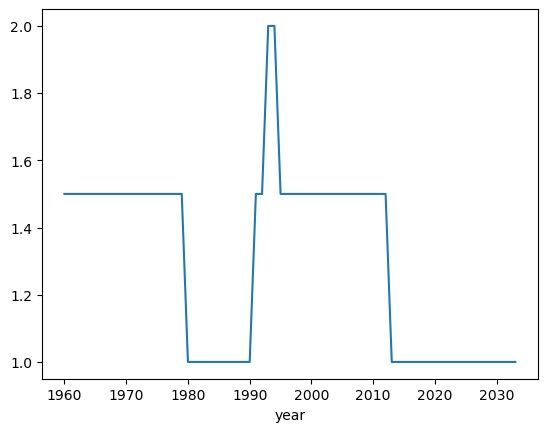

In [21]:
df['JP'].plot()